In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import warnings
warnings.filterwarnings('ignore')


In [6]:
# ==================== STEP 1: LOAD THE DATASET ====================
print("="*50)
print("STEP 1: Loading Dataset")
print("="*50)

df = pd.read_csv('spambase_csv.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

STEP 1: Loading Dataset
Dataset shape: (4601, 58)
Columns: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_%3B', 'char_freq_%28', 'cha

In [8]:
# ==================== STEP 2: PREPROCESS THE DATA ====================
print("\n" + "="*50)
print("STEP 2: Data Preprocessing")
print("="*50)

# Check for missing values
print(f"Missing values: {df.isnull().sum().sum()}")

# Check class distribution
print("\nClass distribution:")
print(df['class'].value_counts())
print(f"Spam (1): {df['class'].sum()} samples ({(df['class'].sum()/len(df))*100:.2f}%)")
print(f"Ham (0): {len(df)-df['class'].sum()} samples ({(1-df['class'].sum()/len(df))*100:.2f}%)")

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Handle any missing values (if found)
if df.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())
    print("\nFilled missing values with mean.")

# Standardize features (CRITICAL for SVM and Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeature statistics after scaling:")
print(f"Mean of first 5 features: {X_scaled.iloc[:, :5].mean().values}")
print(f"Std of first 5 features: {X_scaled.iloc[:, :5].std().values}")


STEP 2: Data Preprocessing
Missing values: 0

Class distribution:
class
0    2788
1    1813
Name: count, dtype: int64
Spam (1): 1813 samples (39.40%)
Ham (0): 2788 samples (60.60%)

Feature statistics after scaling:
Mean of first 5 features: [1.85318688e-17 2.77978032e-17 2.47091584e-17 0.00000000e+00
 4.94183168e-17]
Std of first 5 features: [1.00010869 1.00010869 1.00010869 1.00010869 1.00010869]



STEP 3: Exploratory Data Analysis


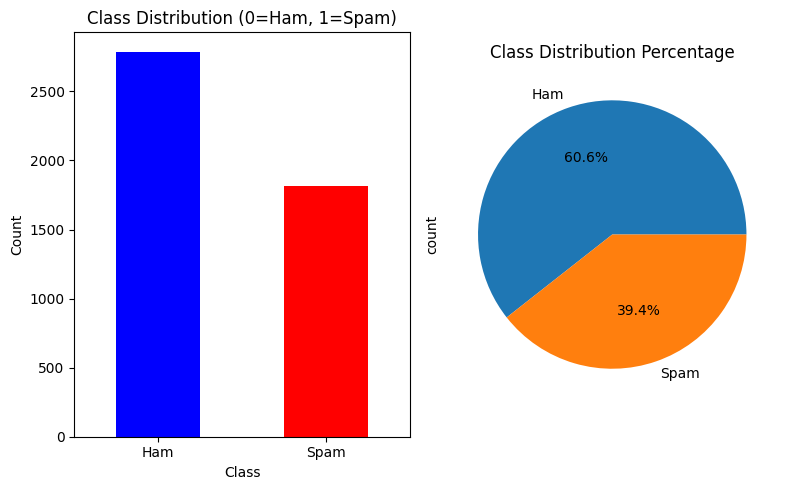


Feature statistics by class:
Top 10 features with highest mean in Spam emails:
capital_run_length_total      470.619415
capital_run_length_longest    104.393271
capital_run_length_average      9.519165
word_freq_you                   2.264539
word_freq_your                  1.380370
word_freq_will                  0.549972
word_freq_free                  0.518362
word_freq_our                   0.513955
char_freq_%21                   0.513713
word_freq_all                   0.403795
dtype: float64

Top 10 features with highest mean in Ham emails:
capital_run_length_total      161.470947
capital_run_length_longest     18.214491
capital_run_length_average      2.377301
word_freq_you                   1.270341
word_freq_george                1.265265
word_freq_hp                    0.895473
word_freq_will                  0.536324
word_freq_your                  0.438702
word_freq_hpl                   0.431994
word_freq_re                    0.415760
dtype: float64


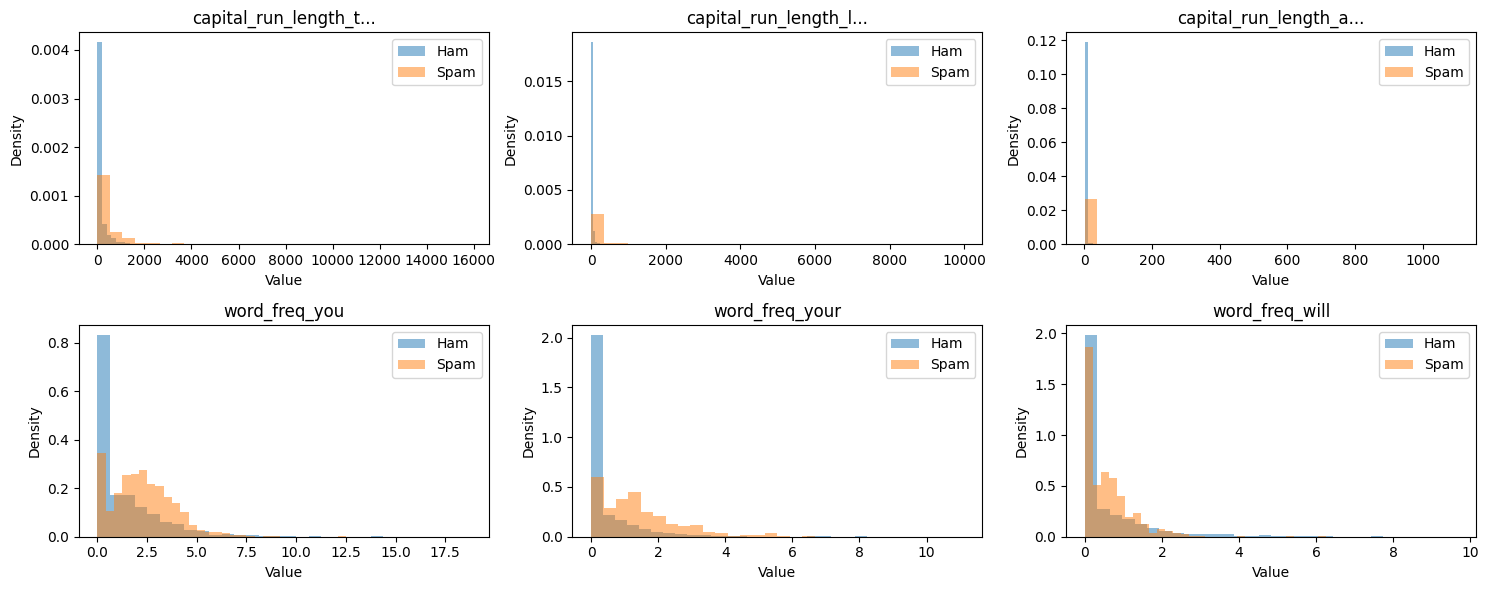

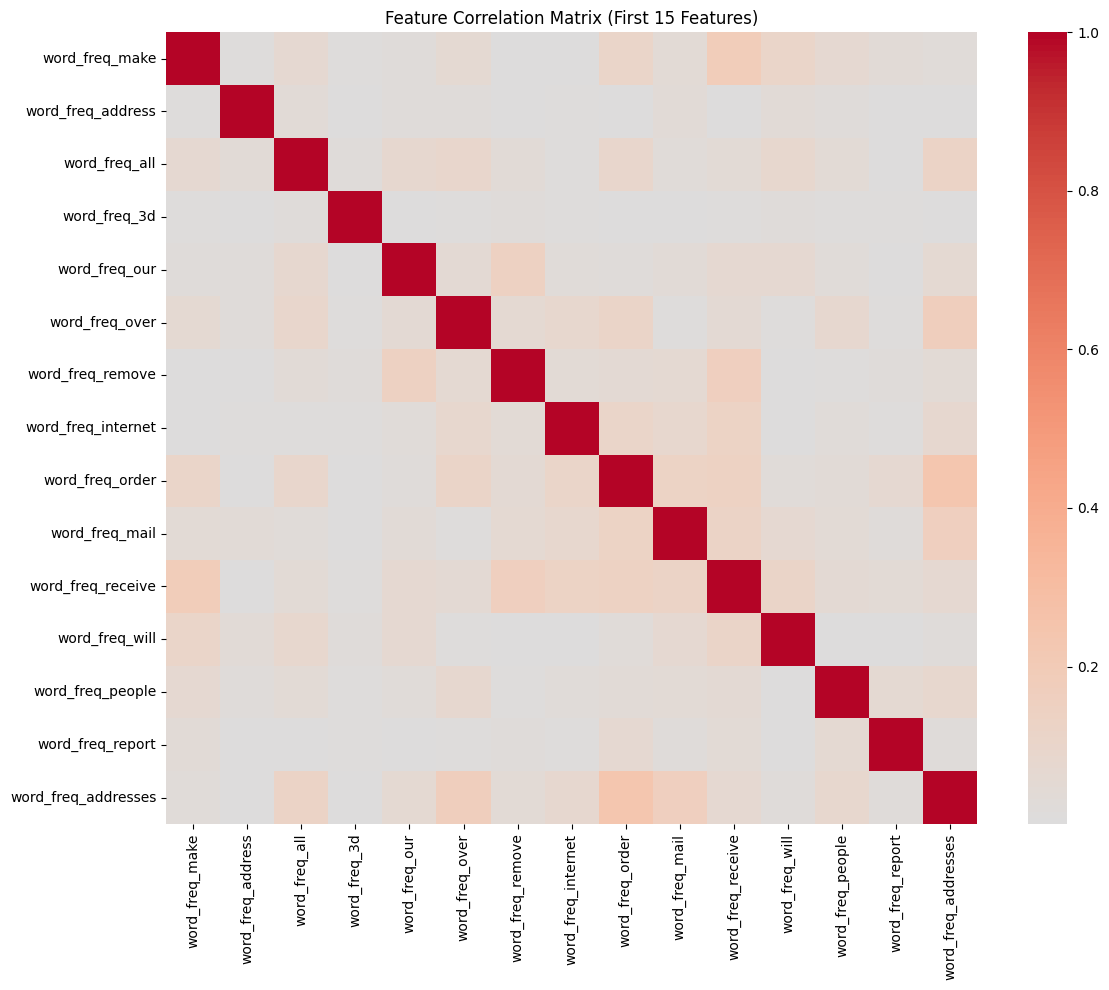

In [9]:
# ==================== STEP 3: EXPLORATORY DATA ANALYSIS ====================
print("\n" + "="*50)
print("STEP 3: Exploratory Data Analysis")
print("="*50)

# 1. Class distribution visualization
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
df['class'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Class Distribution (0=Ham, 1=Spam)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0,1], ['Ham', 'Spam'], rotation=0)

plt.subplot(1,2,2)
df['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Ham', 'Spam'])
plt.title('Class Distribution Percentage')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# 2. Feature statistics by class
print("\nFeature statistics by class:")
print("Top 10 features with highest mean in Spam emails:")
spam_mean = X[y==1].mean().sort_values(ascending=False).head(10)
print(spam_mean)

print("\nTop 10 features with highest mean in Ham emails:")
ham_mean = X[y==0].mean().sort_values(ascending=False).head(10)
print(ham_mean)

# 3. Visualize top features
plt.figure(figsize=(15,6))
top_features = spam_mean.index[:6]  # Top 6 spam indicators

for i, feature in enumerate(top_features):
    plt.subplot(2,3,i+1)
    plt.hist(X[y==0][feature], alpha=0.5, label='Ham', bins=30, density=True)
    plt.hist(X[y==1][feature], alpha=0.5, label='Spam', bins=30, density=True)
    plt.title(f'{feature[:20]}...' if len(feature)>20 else feature)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

# 4. Correlation heatmap (simplified)
plt.figure(figsize=(12,10))
corr_matrix = X.corr().abs()
sns.heatmap(corr_matrix.iloc[:15,:15], annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (First 15 Features)')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

In [10]:
# ==================== STEP 4: SPLIT THE DATASET ====================
print("\n" + "="*50)
print("STEP 4: Train-Test Split")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())


STEP 4: Train-Test Split
Training set size: (3680, 57)
Test set size: (921, 57)

Training class distribution:
class
0    2230
1    1450
Name: count, dtype: int64

Test class distribution:
class
0    558
1    363
Name: count, dtype: int64


In [11]:
# ==================== STEP 5: BASELINE LOGISTIC REGRESSION ====================
print("\n" + "="*50)
print("STEP 5: Baseline Logistic Regression")
print("="*50)

baseline_lr = LogisticRegression(random_state=42, max_iter=1000)
start_time = time.time()
baseline_lr.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_lr_baseline = baseline_lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr_baseline):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr_baseline):.4f}")
print(f"Training Time: {train_time:.4f} seconds")


STEP 5: Baseline Logistic Regression
Accuracy: 0.9294
Precision: 0.9209
Recall: 0.8981
F1 Score: 0.9093
Training Time: 0.2000 seconds


In [12]:
# ==================== STEP 6: TUNE LOGISTIC REGRESSION ====================
print("\n" + "="*50)
print("STEP 6: Hyperparameter Tuning for Logistic Regression")
print("="*50)

# Parameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

# Grid Search
print("\n--- Performing Grid Search ---")
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
lr_grid.fit(X_train, y_train)
grid_time = time.time() - start_time

print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best CV F1 Score: {lr_grid.best_score_:.4f}")
print(f"Grid search time: {grid_time:.2f} seconds")

# Use best model
best_lr = lr_grid.best_estimator_

# Evaluate tuned model
y_pred_lr_tuned = best_lr.predict(X_test)
print(f"\nTuned Logistic Regression Test Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr_tuned):.4f}")


STEP 6: Hyperparameter Tuning for Logistic Regression

--- Performing Grid Search ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV F1 Score: 0.9015
Grid search time: 158.49 seconds

Tuned Logistic Regression Test Performance:
Accuracy: 0.9251
F1 Score: 0.9032


In [13]:
# ==================== STEP 7: SVM WITH DIFFERENT KERNELS (UNTUNED) ====================
print("\n" + "="*50)
print("STEP 7: SVM with Different Kernels (Untuned)")
print("="*50)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_untuned_results = {}

for kernel in kernels:
    print(f"\n--- Training SVM with {kernel} kernel ---")

    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, random_state=42)
    else:
        svm = SVC(kernel=kernel, random_state=42)

    start_time = time.time()
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    svm_untuned_results[kernel] = {
        'model': svm,
        'accuracy': accuracy,
        'f1_score': f1,
        'train_time': train_time
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")


STEP 7: SVM with Different Kernels (Untuned)

--- Training SVM with linear kernel ---
Accuracy: 0.9305
F1 Score: 0.9106
Training Time: 1.0174 seconds

--- Training SVM with poly kernel ---
Accuracy: 0.7796
F1 Score: 0.6220
Training Time: 1.0053 seconds

--- Training SVM with rbf kernel ---
Accuracy: 0.9273
F1 Score: 0.9055
Training Time: 0.8173 seconds

--- Training SVM with sigmoid kernel ---
Accuracy: 0.8838
F1 Score: 0.8524
Training Time: 1.2250 seconds


In [14]:
# ==================== STEP 8: TUNE SVM HYPERPARAMETERS ====================
print("\n" + "="*50)
print("STEP 8: Hyperparameter Tuning for SVM")
print("="*50)

# Parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']  # Excluding poly and sigmoid for speed
}

print("\n--- Performing Grid Search for SVM ---")
svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
svm_grid.fit(X_train, y_train)
svm_grid_time = time.time() - start_time

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV F1 Score: {svm_grid.best_score_:.4f}")
print(f"Grid search time: {svm_grid_time:.2f} seconds")

best_svm = svm_grid.best_estimator_

# Evaluate tuned SVM
y_pred_svm_tuned = best_svm.predict(X_test)
print(f"\nTuned SVM Test Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm_tuned):.4f}")


STEP 8: Hyperparameter Tuning for SVM

--- Performing Grid Search for SVM ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV F1 Score: 0.9144
Grid search time: 210.21 seconds

Tuned SVM Test Performance:
Accuracy: 0.9273
F1 Score: 0.9055


In [22]:
# ==================== STEP 8: TUNE SVM HYPERPARAMETERS ====================
print("\n" + "="*50)
print("STEP 8: Hyperparameter Tuning for SVM")
print("="*50)

# Parameter grid for SVM - including polynomial kernel with degree tuning
svm_param_grid = [
    # For linear and rbf kernels (as you originally had)
    {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    },
    # For polynomial kernel with degree tuning
    {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4],
        'kernel': ['poly']
    }
    # Note: sigmoid kernel is excluded for speed, but you could add it similarly
]

print("\n--- Performing Grid Search for SVM (including polynomial degree tuning) ---")
svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
svm_grid.fit(X_train, y_train)
svm_grid_time = time.time() - start_time

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV F1 Score: {svm_grid.best_score_:.4f}")
print(f"Grid search time: {svm_grid_time:.2f} seconds")

best_svm = svm_grid.best_estimator_

# Evaluate tuned SVM
y_pred_svm_tuned = best_svm.predict(X_test)
print(f"\nTuned SVM Test Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm_tuned):.4f}")


STEP 8: Hyperparameter Tuning for SVM

--- Performing Grid Search for SVM (including polynomial degree tuning) ---
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV F1 Score: 0.9144
Grid search time: 257.93 seconds

Tuned SVM Test Performance:
Accuracy: 0.9273
F1 Score: 0.9055



STEP 9: Comprehensive Model Evaluation

Tuned Logistic Regression Performance
Accuracy:  0.9251
Precision: 0.9200
Recall:    0.8871
F1 Score:  0.9032
Inference Time: 0.0031 seconds


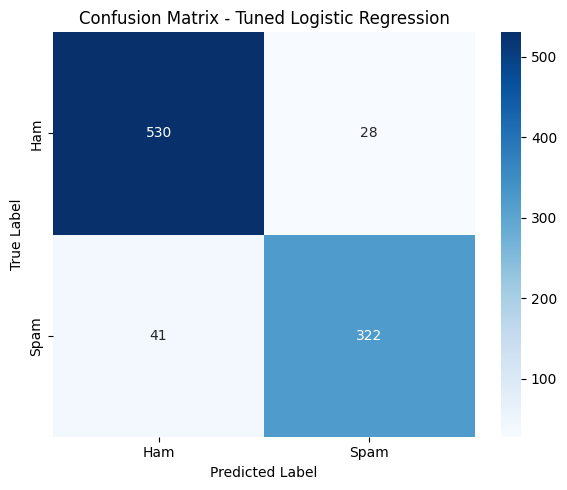


Classification Report:
              precision    recall  f1-score   support

         Ham       0.93      0.95      0.94       558
        Spam       0.92      0.89      0.90       363

    accuracy                           0.93       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.92      0.93      0.92       921


Tuned SVM Performance
Accuracy:  0.9273
Precision: 0.9277
Recall:    0.8843
F1 Score:  0.9055
Inference Time: 0.1740 seconds


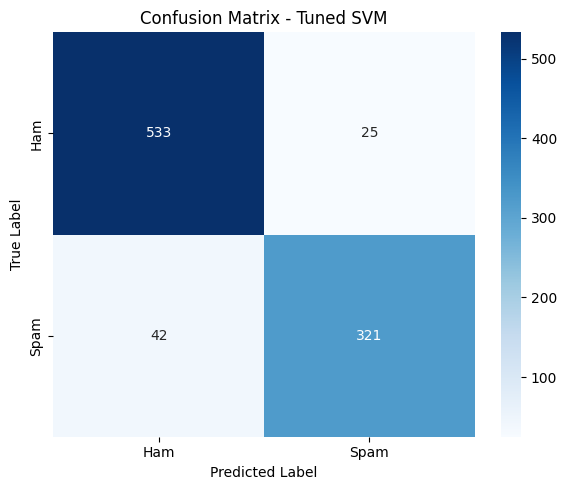


Classification Report:
              precision    recall  f1-score   support

         Ham       0.93      0.96      0.94       558
        Spam       0.93      0.88      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



In [15]:
# ==================== STEP 9: EVALUATE MODELS COMPREHENSIVELY ====================
print("\n" + "="*50)
print("STEP 9: Comprehensive Model Evaluation")
print("="*50)

def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{'='*40}")
    print(f"{model_name} Performance")
    print(f"{'='*40}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")

    # Confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png')
    plt.show()

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

# Evaluate tuned models
lr_results = evaluate_model(best_lr, X_test, y_test, "Tuned Logistic Regression")
svm_results = evaluate_model(best_svm, X_test, y_test, "Tuned SVM")


STEP 10: 5-Fold Cross-Validation

----------------------------------------
5-Fold CV Results for Logistic Regression
----------------------------------------
Fold 1: 0.8943
Fold 2: 0.9121
Fold 3: 0.8756
Fold 4: 0.9364
Fold 5: 0.7880
Mean F1 Score: 0.8813
Std F1 Score:  0.0508

----------------------------------------
5-Fold CV Results for SVM
----------------------------------------
Fold 1: 0.9114
Fold 2: 0.9140
Fold 3: 0.9365
Fold 4: 0.9324
Fold 5: 0.8061
Mean F1 Score: 0.9001
Std F1 Score:  0.0480


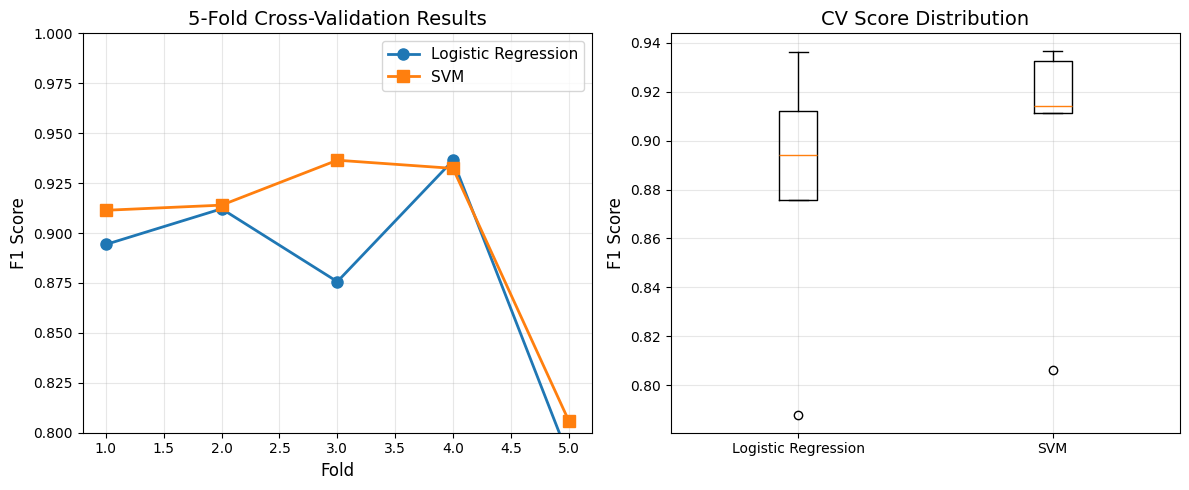

In [16]:
# ==================== STEP 10: CROSS-VALIDATION ====================
print("\n" + "="*50)
print("STEP 10: 5-Fold Cross-Validation")
print("="*50)

def perform_cross_validation(model, X, y, model_name, cv=5):
    """Perform k-fold cross-validation"""
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')

    print(f"\n{'-'*40}")
    print(f"{cv}-Fold CV Results for {model_name}")
    print(f"{'-'*40}")
    for i, score in enumerate(scores, 1):
        print(f"Fold {i}: {score:.4f}")
    print(f"Mean F1 Score: {scores.mean():.4f}")
    print(f"Std F1 Score:  {scores.std():.4f}")

    return scores

# For Logistic Regression
lr_cv_scores = perform_cross_validation(best_lr, X_scaled, y, "Logistic Regression")

# For SVM
svm_cv_scores = perform_cross_validation(best_svm, X_scaled, y, "SVM")

# Visualize CV results
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1,6), lr_cv_scores, 'o-', label='Logistic Regression', linewidth=2, markersize=8)
plt.plot(range(1,6), svm_cv_scores, 's-', label='SVM', linewidth=2, markersize=8)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('5-Fold Cross-Validation Results', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.0)

plt.subplot(1,2,2)
plt.boxplot([lr_cv_scores, svm_cv_scores], labels=['Logistic Regression', 'SVM'])
plt.ylabel('F1 Score', fontsize=12)
plt.title('CV Score Distribution', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cross_validation_results.png')
plt.show()

In [17]:
# ==================== CREATE SUMMARY TABLES ====================
print("\n" + "="*50)
print("SUMMARY TABLES")
print("="*50)

# Table 1: Hyperparameter Tuning Results
tuning_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM'],
    'Search Method': ['Grid Search', 'Grid Search'],
    'Best Parameters': [str(best_lr.get_params()), str(best_svm.get_params())],
    'Best CV Accuracy': [f"{lr_grid.best_score_:.4f}", f"{svm_grid.best_score_:.4f}"]
})

print("\n=== Hyperparameter Tuning Results ===")
print(tuning_results.to_string(index=False))

# Table 2: Logistic Regression Performance
lr_perf = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)'],
    'Value': [
        f"{lr_results['accuracy']:.4f}",
        f"{lr_results['precision']:.4f}",
        f"{lr_results['recall']:.4f}",
        f"{lr_results['f1']:.4f}",
        f"{grid_time:.4f}"
    ]
}

lr_df = pd.DataFrame(lr_perf)
print("\n=== Logistic Regression Performance ===")
print(lr_df.to_string(index=False))

# Table 3: SVM Kernel-wise Performance
svm_kernel_perf = []
for kernel, result in svm_untuned_results.items():
    svm_kernel_perf.append({
        'Kernel': kernel.capitalize(),
        'Accuracy': f"{result['accuracy']:.4f}",
        'F1 Score': f"{result['f1_score']:.4f}",
        'Training Time (s)': f"{result['train_time']:.4f}"
    })

svm_kernel_df = pd.DataFrame(svm_kernel_perf)
print("\n=== SVM Kernel-wise Performance (Untuned) ===")
print(svm_kernel_df.to_string(index=False))

# Table 4: K-Fold Cross-Validation Results
cv_results = pd.DataFrame({
    'Fold': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Average'],
    'Logistic Regression': [
        f"{lr_cv_scores[0]:.4f}",
        f"{lr_cv_scores[1]:.4f}",
        f"{lr_cv_scores[2]:.4f}",
        f"{lr_cv_scores[3]:.4f}",
        f"{lr_cv_scores[4]:.4f}",
        f"{lr_cv_scores.mean():.4f} ± {lr_cv_scores.std():.4f}"
    ],
    'SVM': [
        f"{svm_cv_scores[0]:.4f}",
        f"{svm_cv_scores[1]:.4f}",
        f"{svm_cv_scores[2]:.4f}",
        f"{svm_cv_scores[3]:.4f}",
        f"{svm_cv_scores[4]:.4f}",
        f"{svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}"
    ]
})

print("\n=== K-Fold Cross-Validation Results (K=5) ===")
print(cv_results.to_string(index=False))

# Table 5: Comparative Analysis
comparison = pd.DataFrame({
    'Criterion': ['Accuracy', 'Precision', 'Recall', 'F1 Score',
                  'Model Complexity', 'Training Time (s)', 'Interpretability'],
    'Logistic Regression': [
        f"{lr_results['accuracy']:.4f}",
        f"{lr_results['precision']:.4f}",
        f"{lr_results['recall']:.4f}",
        f"{lr_results['f1']:.4f}",
        'Low',
        f"{grid_time:.2f}",
        'High'
    ],
    'SVM': [
        f"{svm_results['accuracy']:.4f}",
        f"{svm_results['precision']:.4f}",
        f"{svm_results['recall']:.4f}",
        f"{svm_results['f1']:.4f}",
        'High',
        f"{svm_grid_time:.2f}",
        'Low'
    ]
})

print("\n=== Comparative Analysis ===")
print(comparison.to_string(index=False))


SUMMARY TABLES

=== Hyperparameter Tuning Results ===
              Model Search Method                                                                                                                                                                                                                                                                               Best Parameters Best CV Accuracy
Logistic Regression   Grid Search {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}           0.9015
                SVM   Grid Search            {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 's


VISUAL COMPARISON


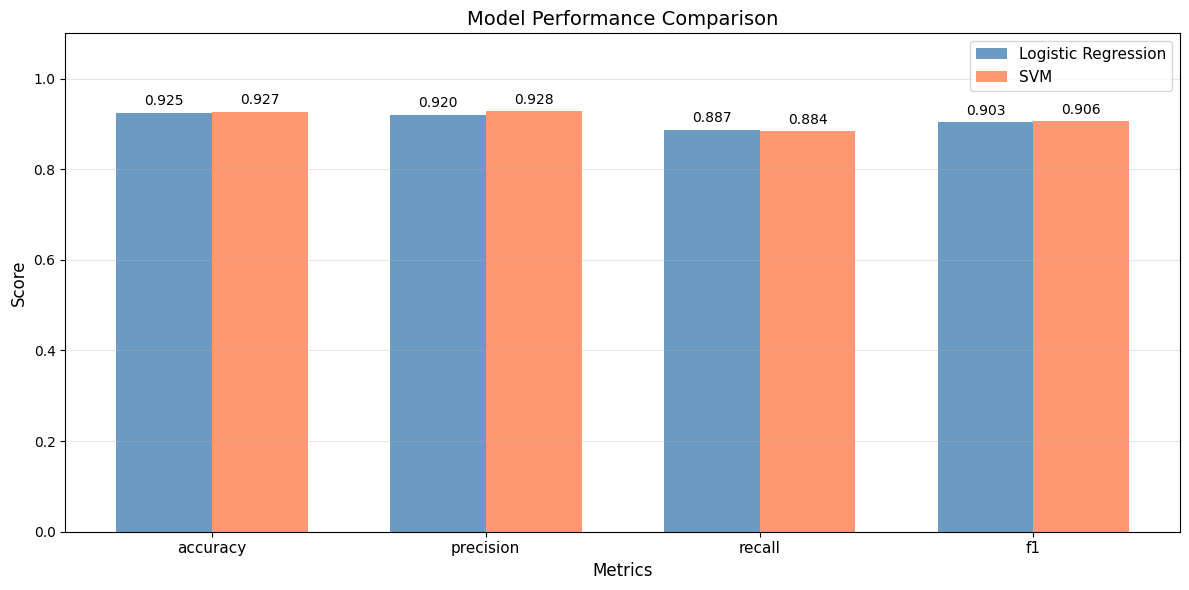

In [18]:
# ==================== VISUAL COMPARISON ====================
print("\n" + "="*50)
print("VISUAL COMPARISON")
print("="*50)

# Model comparison bar chart
models = ['Logistic Regression', 'SVM']
metrics = ['accuracy', 'precision', 'recall', 'f1']
lr_values = [lr_results[m] for m in metrics]
svm_values = [svm_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width/2, lr_values, width, label='Logistic Regression', alpha=0.8, color='steelblue')
bars2 = plt.bar(x + width/2, svm_values, width, label='SVM', alpha=0.8, color='coral')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x, metrics, fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

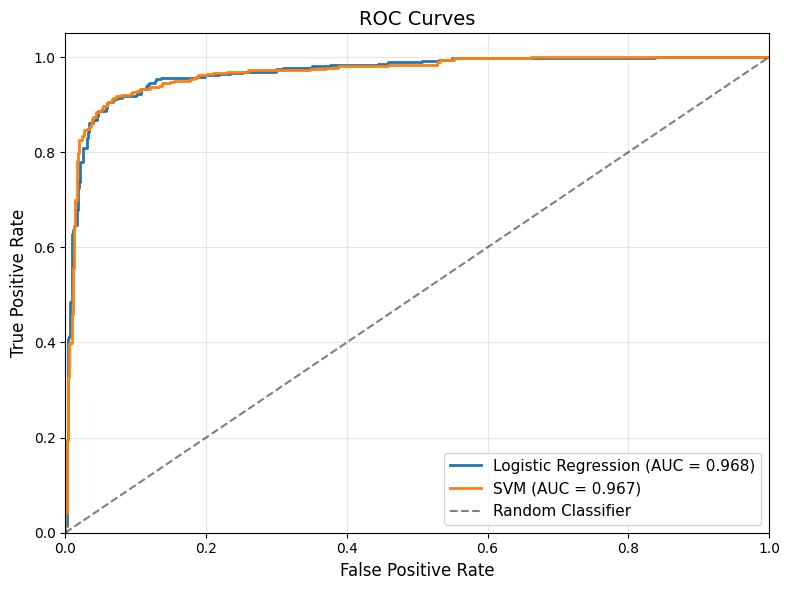

In [19]:
# ==================== ROC CURVE (Optional) ====================
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.figure(figsize=(8,6))

# Logistic Regression
y_pred_lr_proba = best_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', linewidth=2)

# SVM (using decision function)
y_pred_svm_scores = best_svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm_scores)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()

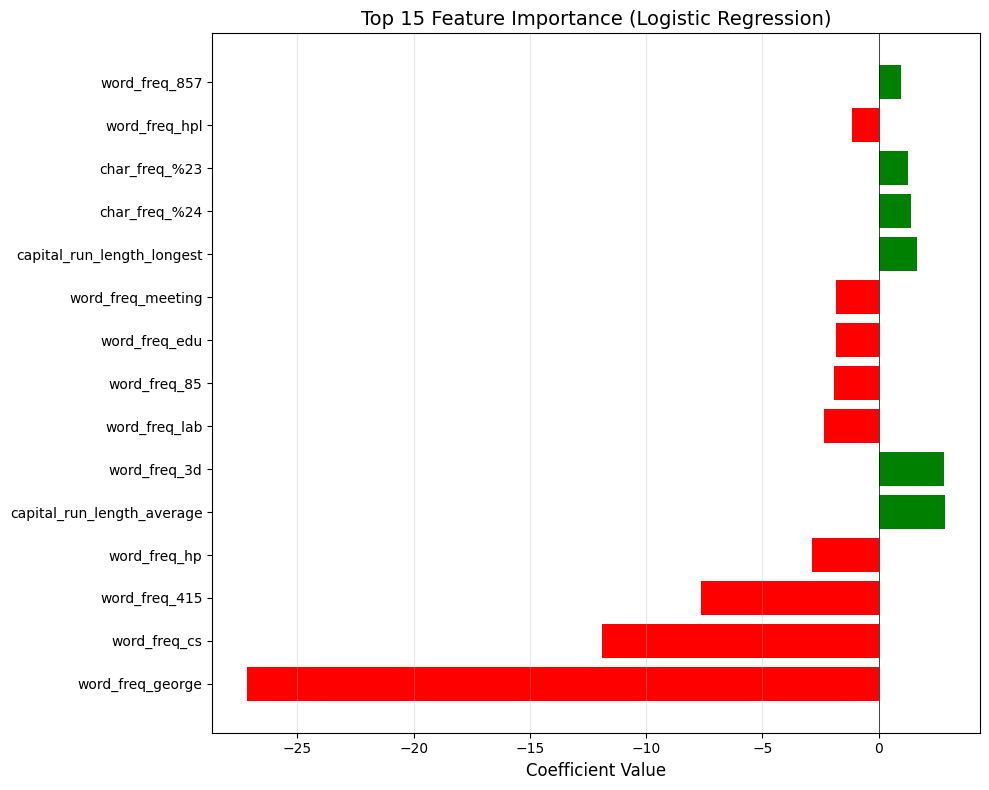

In [20]:
# ==================== FEATURE IMPORTANCE (Logistic Regression) ====================
# Get feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': best_lr.coef_[0]
})
feature_importance['abs_coef'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False).head(15)

plt.figure(figsize=(10,8))
colors = ['red' if x < 0 else 'green' for x in feature_importance['coefficient']]
plt.barh(range(len(feature_importance)), feature_importance['coefficient'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 15 Feature Importance (Logistic Regression)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()